In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

import models
import callbacks

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pad

import os
from typing import Optional, Literal, Dict

In [2]:
img_dir = "images"
log_dir = os.path.join(os.getcwd(), "logs")

log_name = "quadratic"
log_version = ""
log_path = os.path.join(log_dir, log_name, log_version)

metrics_filename = "metrics.csv"

rr_key_prefix = "residuals_ratio_"
mean_rr_key = f"{rr_key_prefix}mean"

coords_key_prefix = "coords_"

# Data creation

In [3]:
n = 2
n_estimators = 1_000
first_n = np.minimum(20, n_estimators)

X = torch.sqrt(torch.tensor([[2, .5]]))
y = torch.zeros(1)
lr = 1 / (2 * X.square().max())

train_data = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(train_data, num_workers=4)

model = models.MultiQuadratic(n=n, n_estimators=n_estimators, lr=lr)

logger = pl.loggers.CSVLogger(log_dir, name=log_name, version=log_version)
es_callback = pl.callbacks.EarlyStopping(mean_rr_key)
cr_callback = callbacks.ResidualsRatioLoggerCallback(key_prefix=rr_key_prefix,
                                                     log_first_n_ratios=first_n)

trainer = pl.Trainer(max_epochs=10_000,
                    callbacks=[es_callback, cr_callback],
                    enable_checkpointing=False,
                    logger=logger,
                    log_every_n_steps=1)
trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
/home/evayness/miniforge3/envs/xp/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:186: UserWarning: Experiment logs directory /home/evayness/Documents/upmc/M1/internship/simulations/logs/quadratic/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

# Data processing

In [4]:
res_ratio_usecols = lambda s: rr_key_prefix in s

rr_df = pad.read_csv(os.path.join(log_path, metrics_filename), usecols=res_ratio_usecols)
res_ratio = np.fliplr(rr_df.to_numpy().squeeze())

actual_n = np.minimum(res_ratio.shape[1] - 1, first_n)

print('Quadratic:\t', res_ratio.size, res_ratio.shape)

Quadratic:	 1680 (80, 21)


In [5]:
def get_color_cycler_for(n: int, cmap: str = "cool"):
    from cycler import cycler
    
    colors = matplotlib.colormaps[cmap]
    color_cycler = cycler("color", [colors(alpha) for alpha in np.linspace(0, 1, n)])
    return color_cycler

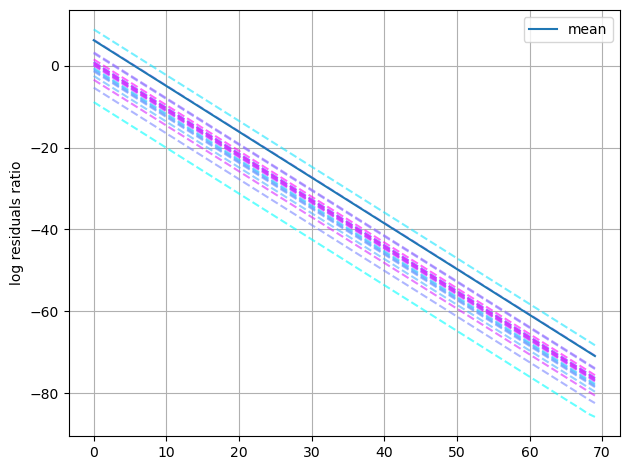

In [7]:
fig, ax = plt.subplots(layout="tight")

first_zero_index = np.where(res_ratio == 0)[0][0]
if actual_n > 0:
    ax.set_prop_cycle(get_color_cycler_for(actual_n))
    ax.plot(np.log(res_ratio[:first_zero_index, 1:actual_n+1]), alpha=0.6, ls='--')
    ax.set_prop_cycle(None)

ax.plot(np.log(res_ratio[:first_zero_index, 0]), label="mean")

# ax1.set_xlim(0, int(first_zero_index * 1.15))
ax.set_ylabel("log residuals ratio")
ax.grid("on")
ax.legend()

path = os.path.join(img_dir, "quad_log_residuals_ratio_pl.pdf")
fig.savefig(path)
plt.show()